In [77]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [78]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import graphviz 

# 데이터 경로
file_path = "/gdrive/MyDrive/colab/PlayTennis.csv"
# 데이터 경로로부터 파일을 읽음 (pandas 라이브러리 사용)
datas = pd.read_csv(file_path)

# 데이터 출력 (데이터 형태 확인)
print(datas)

     outlook  temp humidity  windy  day      time play
0      sunny   hot     high  False  Mon  10-15-27   no
1      sunny   hot     high   True  Tue  09-33-14   no
2   overcast   hot     high  False  Wed  08-18-22  yes
3      rainy  mild     high  False  Sat  19-12-44  yes
4      rainy  cool   normal  False  Sun  20-47-55  yes
5      rainy  cool   normal   True  Thu  22-08-43   no
6   overcast  cool   normal   True  Sat  14-34-22  yes
7      sunny  mild     high  False  Mon  07-50-11   no
8      sunny  cool   normal  False  Sun  13-37-27  yes
9      rainy  mild   normal  False  Sat  12-57-13  yes
10     sunny  mild   normal   True  Sun  13-12-44  yes
11  overcast  mild     high   True  Fri  17-21-54  yes
12  overcast   hot   normal  False  Sat  14-00-24  yes
13     rainy  mild     high   True  Tue  16-31-14   no


In [79]:
# 범주형 데이터를 수치형 데이터로 자동 변환해주는 라이브러리
label_encoder = LabelEncoder()

# 정답 클래스 이름 (yes, no)
target_names = label_encoder.fit(datas['play']).classes_
print("target_names : {}".format(target_names))

datas['outlook'] = label_encoder.fit_transform(datas['outlook'])
datas['temp'] = label_encoder.fit_transform(datas['temp'])
datas['humidity'] = label_encoder.fit_transform(datas['humidity'])
datas['windy'] = label_encoder.fit_transform(datas['windy'])
datas['play'] = label_encoder.fit_transform(datas['play'])

#feature가 복잡할수록 빈도가 낮아서 엔트로피가 높게 측정됨. 요일을 두 가지로 분류함.
#Tree의 깊이가 깊어질수록 overfitting이 일어날 확률이 높아지므로
#Tree의 깊이를 작게 하면서 가능한 적은 결정 노드로 높은 예측 정확도를 가지게 하기 위해
#결정 노드에서 최대한 많은 데이터 세트가 한 분류에 속할 수 있도록 데이터를 세팅함. 
#월~금을 weekday, 주말을 weekend로 분류함.
datas.loc[datas.day == 'Sat', ('day')] = 'weekend'
datas.loc[datas.day == 'Sun', ('day')] = 'weekend'
datas.loc[datas.day != 'weekend', ('day')] = 'weekday'

datas['day'] = label_encoder.fit_transform(datas['day'])

#시간은 연속 자질이므로 이산적으로 변환해주어야 함.
#요일과 마찬가지로 시간도 두 가지로 분류함.
#12:00~18:00 시간대 => peak, 나머지 시간대는 => soso

temp = pd.DataFrame(datas.time.str.split('-',2).tolist(), columns=['hour','min','sec'])
temp = temp.apply(pd.to_numeric)
temp['name'] = 0
temp.loc[temp['hour'] <= 11, 'name'] = 'soso'
temp.loc[ (temp['hour'] >= 18) & (temp['min'] != 0) & (temp['sec'] != 0), 'name'] = 'soso'
temp.loc[temp['name'] != 'soso', 'name'] = 'peak'
#print(temp)

datas['time'] = temp['name']

datas['time'] = label_encoder.fit_transform(datas['time'])

# 데이터 출력 (데이터 포맷 변환 후 결과 확인)
print(datas)

target_names : ['no' 'yes']
    outlook  temp  humidity  windy  day  time  play
0         2     1         0      0    0     1     0
1         2     1         0      1    0     1     0
2         0     1         0      0    0     1     1
3         1     2         0      0    1     1     1
4         1     0         1      0    1     1     1
5         1     0         1      1    0     1     0
6         0     0         1      1    1     0     1
7         2     2         0      0    0     1     0
8         2     0         1      0    1     0     1
9         1     2         1      0    1     0     1
10        2     2         1      1    1     0     1
11        0     2         0      1    0     0     1
12        0     1         1      0    1     0     1
13        1     2         0      1    0     0     0


In [80]:
# 입력 데이터와 정답 데이터로 분리
x_data, y_data = datas.drop(['play'], axis=1), datas['play']

# 분리 결과 확인
print(x_data)
print()
print(y_data)

    outlook  temp  humidity  windy  day  time
0         2     1         0      0    0     1
1         2     1         0      1    0     1
2         0     1         0      0    0     1
3         1     2         0      0    1     1
4         1     0         1      0    1     1
5         1     0         1      1    0     1
6         0     0         1      1    1     0
7         2     2         0      0    0     1
8         2     0         1      0    1     0
9         1     2         1      0    1     0
10        2     2         1      1    1     0
11        0     2         0      1    0     0
12        0     1         1      0    1     0
13        1     2         0      1    0     0

0     0
1     0
2     1
3     1
4     1
5     0
6     1
7     0
8     1
9     1
10    1
11    1
12    1
13    0
Name: play, dtype: int64


In [81]:
# Decision tree 모델 학습 ()
decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy')
train_result = decision_tree.fit(x_data, y_data)

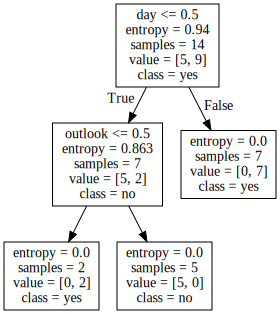

In [82]:
# 학습 결과 확인 (graphviz 라이브러리 사용)
graph = graphviz.Source(tree.export_graphviz(train_result, out_file=None,
                                             feature_names=x_data.columns,
                                             class_names=target_names)) 
graph

In [83]:
# 학습한 모델을 사용하여 예측
predict_result = decision_tree.predict(x_data)

# 예측 결과 출력 (실제 정답을 맞춘 경우 True로 표시됨)
print(predict_result == y_data)

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
Name: play, dtype: bool
